In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


In [2]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


In [3]:
lgb = pd.read_csv(r'../predictions/lgb_predictions.csv')
lgb.shape


(16523, 8)

In [4]:
lstm = pd.read_csv(r'../predictions/rnn_predictions.csv')
lstm.shape


(16100, 14)

In [5]:
lstm2d = pd.read_csv(r'../predictions/2d_rnn_predictions.csv')
lstm.shape


(16100, 14)

In [6]:
lstm = pd.merge(lstm, lgb[['filename', 'trip_number', 'latitude_lgb_predicted',
                           'longitude_lgb_predicted']], on=['filename', 'trip_number'], how='inner')
lstm = pd.merge(lstm, lstm2d[['filename', 'trip_number', 'latitude_2d_rnn_predicted',
                              'longitude_2d_rnn_predicted']], on=['filename', 'trip_number'], how='inner')


# RMSE

In [7]:
print('Latitude: RMSE LSTM {0:0.4f}, RMSE 2D LSTM {1:0.4f}, RMSE LGB {2:0.4f}'.format(mean_squared_error(lstm.latitude_true, lstm.latitude_rnn_predicted),
                                                                                      mean_squared_error(lstm.latitude_true, lstm.latitude_2d_rnn_predicted),
                                                                                      mean_squared_error(lstm.latitude_true, lstm.latitude_lgb_predicted)))


Latitude: RMSE LSTM 0.0038, RMSE 2D LSTM 0.0029, RMSE LGB 0.0024


In [8]:
print('Longitude: RMSE LSTM {0:0.4f}, RMSE 2D LSTM {1:0.4f}, RMSE LGB {2:0.4f}'.format(mean_squared_error(lstm.longitude_true, lstm.longitude_rnn_predicted),
                                                                                       mean_squared_error(lstm.longitude_true, lstm.longitude_2d_rnn_predicted),
                                                                                       mean_squared_error(lstm.longitude_true, lstm.longitude_lgb_predicted)))


Longitude: RMSE LSTM 0.0009, RMSE 2D LSTM 0.0005, RMSE LGB 0.0006


# Kilometers between predicted and actual pickup locations

In [9]:
lstm['rnn_haversine_error'] = \
    haversine(lstm.latitude_rnn_predicted, lstm.longitude_rnn_predicted,
              lstm.latitude_true, lstm.longitude_true)

lstm['2d_rnn_haversine_error'] = \
    haversine(lstm.latitude_2d_rnn_predicted, lstm.longitude_2d_rnn_predicted,
              lstm.latitude_true, lstm.longitude_true)

In [10]:
lstm['lgb_haversine_error'] = \
    haversine(lstm.latitude_lgb_predicted, lstm.longitude_lgb_predicted,
              lstm.latitude_true, lstm.longitude_true)


In [11]:
lstm['rnn_haversine_error'].mean(), lstm['2d_rnn_haversine_error'].mean(), lstm['lgb_haversine_error'].mean()


(5.057703493103932, 4.093823430880947, 4.042947215545546)

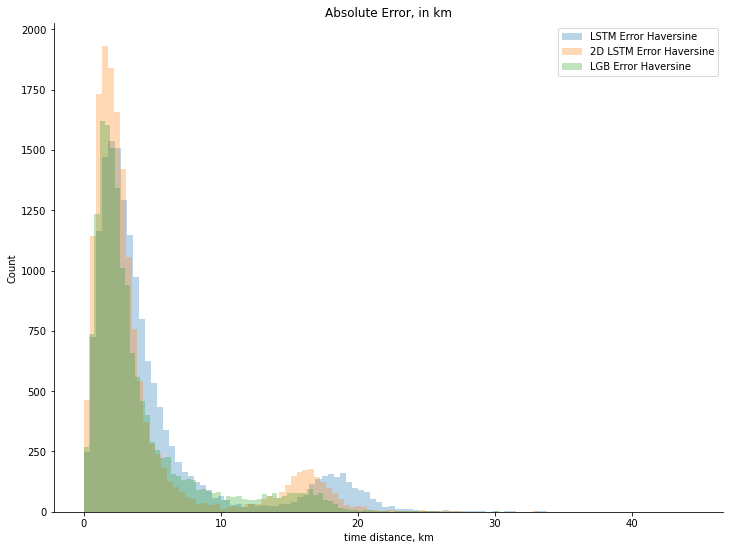

In [13]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.xlabel("time distance, km")
plt.ylabel("Count")

plt.hist(lstm['rnn_haversine_error'],
         bins=100, label='LSTM Error Haversine', alpha=0.3)

plt.hist(lstm['2d_rnn_haversine_error'],
         bins=100, label='2D LSTM Error Haversine', alpha=0.3)

plt.hist(lstm['lgb_haversine_error'],
         bins=100, label='LGB Error Haversine', alpha=0.3)
plt.title('Absolute Error, in km')
plt.legend()
plt.show()
